In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import gurobipy as gp
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,RepeatedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
# Reading train data
X_train = pd.read_csv('training_data.csv')
y_train=X_train.iloc[:,0]
X_train.iloc[:,0]=1
X_train = X_train.rename({'y': 'X0'}, axis=1)

# Reading Test Data
X_test = pd.read_csv('test_data.csv')
y_test=X_test.iloc[:,0]
X_test.iloc[:,0]=1
X_test = X_test.rename({'y': 'X0'}, axis=1)

General form of Quadratic:

Objective function: $ x^{T}Qx + c^{T}x $<br>
s.t.<br> 
$ Ax  \le b $<br>
$ x  \ge 0 $



Lasso Regression:

Decision Variables:
1. $ \beta_{0}, \beta_{1} ... \beta_{m}$ - Coefficients - (m+1)
2. $ z_{1}, z_{2} ... z_{m}$ - Decison to keep the variable to drop it from regression - (m) <br>

Constraints:
1. Coefs ($\beta_{i}$) shoud be within a given range ($|M|$) and should be non-zero iff $z_{i} > 0$ - (2m)
2. Total number of coefs in final model should be less than k - (1) <br>

Total Constraint equations - 2m +1

Objective function for lasso: $$ \beta^{T}(X^{T}X)\beta + (-2y^{T}X)\beta$$<br>
s.t.<br> 
$$ -z_{i}M < \beta_{i} < z_{i}M $$   for i=1,2...m<br>
$$ \sum_{i=1}^m z_{i} \le k $$


$ Q =(X^{T}X) $<br>
$ c =(-2y^{T}X) $

In [3]:

# Define a function to perform k-fold cross validation. In this case we are doing a 10-fold cross validation. 
# Since there are 50 Independent variables, k = 5,10,15,...45,50. 
# In this case Mixed Integer Quadratic programming has to run for 100 times.
# We need to check which K has the lowest validation error 

def Mixed_Int_Quad_Program(k,train_x,test_x, train_y,test_y):
    #print("K-Value: ", k)
    M=20
    C=0
    m=train_x.shape[1]-1
    n=train_x.shape[0]
    
    X=train_x.to_numpy()
    
    #Objective Functions
    
    Q=np.zeros((2*m+1,2*m+1)) #Initializing Objective function with 0's
    Q[:m+1,:m+1] = X.T @ X    # Defining objective function
    
    c=np.zeros((2*m+1))
    c[:m+1]=-2*(train_y.to_numpy()).T@X
    
    # Initializing constant matrix
    
    equation_count = (2 * m) + 1
    decision_variable_count = (2 * m) + 1
    A=np.zeros((equation_count,decision_variable_count))
    b=np.zeros((equation_count,1))
    
    # Preparing constant matrices
    # z_i are binary variables used to decide if the feature is important or not
    
    # 1 * beta_i - M * z_i < 0 
    for p in range(m):
        A[p , 1 + p] = 1
        A[p , 1 + p + m] = M
    
    # -1 * beta_i - M * z_i < 0 
    for p in range(m):
        A[p + m , 1 + p] = 1
        A[p + m , 1 + p + m] = -M
    
    for p in range(m + 1 ,2 * m + 1):
        A[2 * m , p] = 1
    b[2 * m] = k
    
    # Preparing the sense matrix
    sense = ['>'] * m + ['<'] * (m + 1)
    vtype = ['C'] * (m + 1) + ['B'] * m
    
    # As gurobi assumes all decision variables as as positive
    # To allow coeffiients to take negative values, set lb value to -M 
    lb = [-M] * (m + 1) + [0] * m
    
    
    # Gurobi Model
    model = gp.Model()
    modelX = model.addMVar(2 * m + 1, lb=lb, ub=None, vtype=vtype)
    modelConstr = model.addMConstr(A, modelX, sense, b)
    model.setMObjective(Q,c,C, sense = gp.GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    # setting a timer for 1 hour
    model.Params.timeLimit = 3600 
    model.optimize()
    
    coefficients = modelX.x[:m+1]
    
    for b in coefficients:
        if b == M or b == -M:
            print("Coefficients are Bounded")
    
    return mean_squared_error(test_y, test_x @ modelX.x[:m+1])
    


In [5]:

Rows = [p*5 for p in range(1,11)]
Columns = [p for p in range(1,11)]
mse_df = pd.DataFrame(index=Rows , columns=Columns)

# Taking k-fold value as 10 to check for best K value based on mse
cv = 10
x = 0
for k in Rows:
    
    print("K-Value in this iteration is :", k)
    cross_val = 0
    
    k_fold = KFold(cv, shuffle=True, random_state=10)
    
    for train_index, test_index in k_fold.split(X_train):
        
        train_x, test_x = X_train.iloc[train_index,:], X_train.iloc[test_index,:] 
        train_y, test_y = y_train[train_index], y_train[test_index]
        
        # find the mean squared error for each k value for 10 folds
        # for each fold, mixed int quad programing is calculated 10 times
        
        mse_df.iloc[x , cross_val]=Mixed_Int_Quad_Program(k , train_x , test_x , train_y , test_y)
        print(mse_df.iloc[x , cross_val])
        
        cross_val += 1
    x += 1
    

K-Value in this iteration is : 5
K-Value:  5
3.9896530907488725
K-Value:  5
3.668455900343341
K-Value:  5
3.6282492536313935
K-Value:  5
3.0163257256343927
K-Value:  5
4.137824273054038
K-Value:  5
2.9502410769054546
K-Value:  5
4.005491157505689
K-Value:  5
3.002222349040683
K-Value:  5
5.135943434538257
K-Value:  5
3.1622974176537126
K-Value in this iteration is : 10
K-Value:  10
3.0873768076739787
K-Value:  10
2.6914310792532143
K-Value:  10
2.5987444613618296
K-Value:  10
3.104282546825342
K-Value:  10
3.654778978361792
K-Value:  10
2.7227018393073816
K-Value:  10
3.0851958211024697
K-Value:  10
2.7644819950286514
K-Value:  10
3.139730401247811
K-Value:  10
1.8250475239871813
K-Value in this iteration is : 15
K-Value:  15
3.051939160336019
K-Value:  15
2.586483392150758
K-Value:  15
2.4920014798441956
K-Value:  15
3.2390332945044906
K-Value:  15
3.7999882779230636
K-Value:  15
3.157607887482222
K-Value:  15
3.6287234954959073
K-Value:  15
2.997250993472328
K-Value:  15
3.6730363211

In [6]:
print("MSE Values for each K value across 10 folds : ",mse_df)

MSE Values for each K value across 10 folds :            1         2         3         4         5         6         7   \
5   3.989653  3.668456  3.628249  3.016326  4.137824  2.950241  4.005491   
10  3.087377  2.691431  2.598744  3.104283  3.654779  2.722702  3.085196   
15  3.051939  2.586483  2.492001  3.239033  3.799988  3.157608  3.628723   
20  3.069909  2.612931  2.940455  3.249115  3.825879    3.4352   3.85728   
25  2.700598  2.542442  2.663355  3.168037  3.815658  3.746373  3.664893   
30  2.853712  2.933952  3.189938  3.187329  3.801332  3.597326  4.006988   
35  3.230019  3.045027   3.13641   3.39008   3.46865  3.617229  4.021677   
40  3.278053   2.95303  3.157792   3.43824  3.583962  3.593547   4.10417   
45  3.221199  3.006661    3.2932  3.385424  3.570978  3.611326  4.152091   
50  3.167247  3.000676  3.314224  3.365449  3.571293  3.609335  4.220439   

          8         9         10  
5   3.002222  5.135943  3.162297  
10  2.764482   3.13973  1.825048  
15  2.99725

In [7]:
mean_mse = mse_df.mean(axis=1)
print("Best K with minimum MSE is : ",mean_mse[mean_mse == mean_mse.min()])

Best K with minimum MSE is :  10    2.867377
dtype: float64


Text(0.5, 1.0, 'Average MSE-Values as function of K-values')

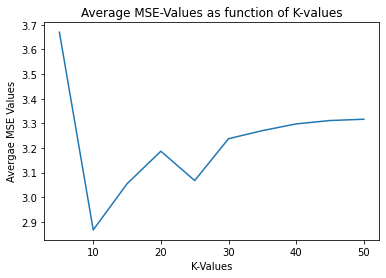

In [8]:
# Plot Avg MSE vs K values 
plt.plot(Rows, mean_mse)
plt.xlabel("K-Values")
plt.ylabel("Avergae MSE Values")
plt.title("Average MSE-Values as function of K-values")

In [10]:
mean_mse.to_csv('optimal_k_value.csv')

In [11]:
Mixed_Int_Quad_Program(10,X_train,X_test,y_train,y_test)

K-Value:  10


2.3365439645525248

# Lasso Regression 

In [12]:
cross_val = KFold(n_splits=10, shuffle=True, random_state=10)

lasso_regression = LassoCV(cv = cross_val).fit(X_train,y_train)
print('Non-zero Coefficients of Lasso Regression ',   sum(lasso_regression.coef_ != 0))

y_pred = lasso_regression.predict(X_train)
print("MSE on Train Data is :", mean_squared_error(y_pred,y_train))

y_pred = lasso_regression.predict(X_test)
print("MSE on Test Data is :", mean_squared_error(y_pred,y_test))

Non-zero Coefficients of Lasso Regression  18
MSE on Train Data is : 2.3583500089229474
MSE on Test Data is : 2.3467369853530413
